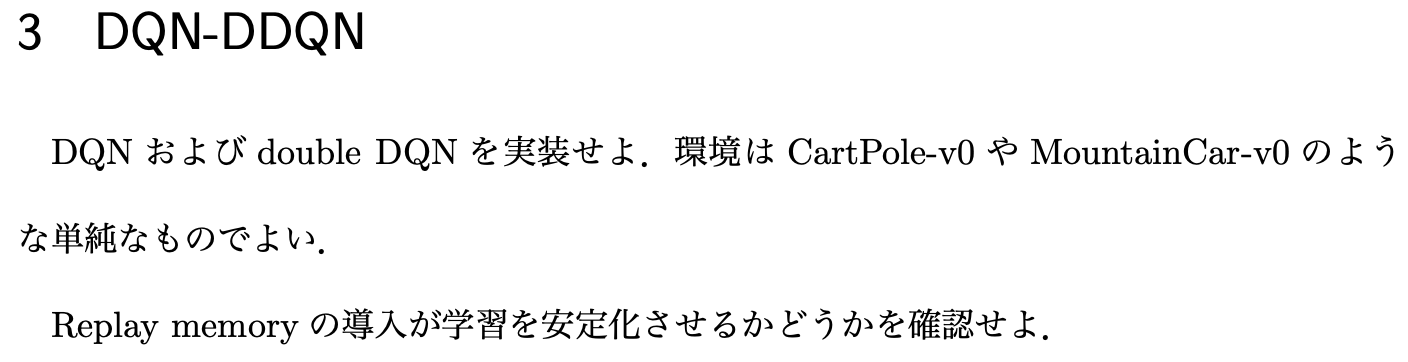

- DONの実装には以下のサイトを全面的に参考にした。なお、DeZeroというニューラルネットワークのパッケージを使用している。
- 【公開レビュー】ゼロから作るDeep Learning 4 https://tree-radius-a8e.notion.site/Deep-Learning-d47ea41a980c492c8ab3cddccb36ba83

In [142]:
import gym
import numpy as np
import tensorflow as tf
import collections
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import japanize_matplotlib
import pyglet
%matplotlib nbagg

- https://qiita.com/ishizakiiii/items/75bc2176a1e0b65bdd16
- 公式サイト　https://gym.openai.com/envs/#classic_control
- 以下、生成できる環境の一覧

In [22]:
from gym import envs
envids = [spec.id for spec in envs.registry.all()]

In [23]:
envids

['ALE/Tetris-v5',
 'ALE/Tetris-ram-v5',
 'ALE/Asterix-v5',
 'ALE/Asterix-ram-v5',
 'ALE/Asteroids-v5',
 'ALE/Asteroids-ram-v5',
 'ALE/MsPacman-v5',
 'ALE/MsPacman-ram-v5',
 'ALE/Kaboom-v5',
 'ALE/Kaboom-ram-v5',
 'ALE/BankHeist-v5',
 'ALE/BankHeist-ram-v5',
 'ALE/Backgammon-v5',
 'ALE/Backgammon-ram-v5',
 'ALE/Klax-v5',
 'ALE/Klax-ram-v5',
 'ALE/Crossbow-v5',
 'ALE/Crossbow-ram-v5',
 'ALE/Kangaroo-v5',
 'ALE/Kangaroo-ram-v5',
 'ALE/Skiing-v5',
 'ALE/Skiing-ram-v5',
 'ALE/FishingDerby-v5',
 'ALE/FishingDerby-ram-v5',
 'ALE/Krull-v5',
 'ALE/Krull-ram-v5',
 'ALE/FlagCapture-v5',
 'ALE/FlagCapture-ram-v5',
 'ALE/BasicMath-v5',
 'ALE/BasicMath-ram-v5',
 'ALE/Berzerk-v5',
 'ALE/Berzerk-ram-v5',
 'ALE/Tutankham-v5',
 'ALE/Tutankham-ram-v5',
 'ALE/MarioBros-v5',
 'ALE/MarioBros-ram-v5',
 'ALE/Zaxxon-v5',
 'ALE/Zaxxon-ram-v5',
 'ALE/Venture-v5',
 'ALE/Venture-ram-v5',
 'ALE/Riverraid-v5',
 'ALE/Riverraid-ram-v5',
 'ALE/Centipede-v5',
 'ALE/Centipede-ram-v5',
 'ALE/WordZapper-v5',
 'ALE/WordZapp

## 1. MountainCarとQ learning

- MountainCarの.pyコード　https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

In [2]:
e = gym.make('MountainCar-v0')
obs = e.reset()
print("行動空間", e.action_space)# 行動空間は3つ（0: 左にアクセル、1: 加速しない、2: 右にアクセル）
print("観測空間", e.observation_space)# 観測空間（[最低位置, -最高速度],[最高位置, 最高速度]）
print("初期値",obs)# 初期値（位置: -0.6〜-0.4の一様分布, 早さ: 0,リセットの都度変わる）

print(e.step(0))# [state],reward (到着すれば0, しなければ-1), done

行動空間 Discrete(3)
観測空間 Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
初期値 [-0.5852562  0.       ]
(array([-5.8579648e-01, -5.4020144e-04], dtype=float32), -1.0, False, {})


In [3]:
# 加速しないと初期位置からほとんど変わらない
while True:
    s, r, finish, data = e.step(1)
    print(s, r)
    if finish:
        break

[-5.858729e-01 -7.642111e-05] -1.0
[-5.8548492e-01  3.8792242e-04] -1.0
[-0.58463556  0.00084941] -1.0
[-0.5833309   0.00130463] -1.0
[-0.5815807   0.00175023] -1.0
[-0.5793978  0.0021829] -1.0
[-0.5767983   0.00259944] -1.0
[-0.5738016   0.00299675] -1.0
[-0.57042974  0.00337185] -1.0
[-0.56670785  0.00372192] -1.0
[-0.5626635   0.00404434] -1.0
[-0.55832684  0.00433666] -1.0
[-0.5537302   0.00459665] -1.0
[-0.5489079   0.00482232] -1.0
[-0.5438959   0.00501196] -1.0
[-0.5387318   0.00516409] -1.0
[-0.53345424  0.00527755] -1.0
[-0.5281028   0.00535146] -1.0
[-0.52271754  0.00538524] -1.0
[-0.51733893  0.00537863] -1.0
[-0.51200724  0.00533168] -1.0
[-0.5067625   0.00524476] -1.0
[-0.50164396  0.00511854] -1.0
[-0.49668995  0.004954  ] -1.0
[-0.49193755  0.0047524 ] -1.0
[-0.48742223  0.0045153 ] -1.0
[-0.48317772  0.00424451] -1.0
[-0.47923562  0.0039421 ] -1.0
[-0.47562528  0.00361035] -1.0
[-0.4723735   0.00325179] -1.0
[-0.46950436  0.00286911] -1.0
[-0.46703917  0.00246518] -1.0


In [23]:
print(env.observation_space.low) # array([-1.2 , -0.07], dtype=float32)
print(env.observation_space.high)# array([0.6  0.07], dtype=float32)

[-1.2  -0.07]
[0.6  0.07]


In [27]:
env = gym.make('MountainCar-v0')
epsilon = 0.02 # epsilon-greedy
gamma = 0.99 # 割引率
eta = 0.2 # 学習係数

state_dim = env.observation_space.shape[0] # 次元（座標、加速度）2
num_actions = env.action_space.n # 左，ブレーキ、右 0:2:
animation_interval = 20

# 状態の離散化
bins = 40 # 40等分
env_low = env.observation_space.low # 位置と速度の最小値
env_high = env.observation_space.high #　位置と速度の最大値
env_dx = (env_high - env_low) / bins

def get_status(_observation):
    # 0〜39の離散値に変換する
    position = int((_observation[0] - env_low[0])/env_dx[0])
    velocity = int((_observation[1] - env_low[1])/env_dx[1])
    return position, velocity

q_table = np.zeros((bins, bins, num_actions))# ゼロ配列に。ランダム配列が良い？

# Q関数の更新
def update_q_table(_q_table, _action,  _observation, _next_observation, _reward, _episode):

    # 行動後の状態で得られる最大行動価値 Q(s',a')
    next_position, next_velocity = get_status(_next_observation)# 観測を離散値化
    next_max_q_value = max(_q_table[next_position][next_velocity])

    # 行動前の状態の行動価値 Q(s,a)
    position, velocity = get_status(_observation)
    q_value = _q_table[position][velocity][_action]

    # 行動価値関数の更新
    _q_table[position][velocity][_action] = q_value + eta * (_reward + gamma * next_max_q_value - q_value)

    return _q_table

# e-greedy（行動を返す）
def get_action(_env, _q_table, _observation, _episode):
    if np.random.uniform(0, 1) > epsilon:
        position, velocity = get_status(observation)# 観測を離散値化
        _action = np.argmax(_q_table[position][velocity])
    else:
        _action = np.random.choice([0, 1, 2])
    return _action

In [28]:
if __name__ == '__main__':

    # Qテーブルの初期化
    q_table = np.zeros((40, 40, 3))

    observation = env.reset()
    rewards = []
    t_epi_reward = np.zeros(100)

    # 10000エピソードで学習する
    for episode in range(10000):

        total_reward = 0
        observation = env.reset()

        for _ in range(200):

            # ε-グリーディ法で行動を選択
            action = get_action(env, q_table, observation, episode)

            # 車を動かし、観測結果・報酬・ゲーム終了FLG・詳細情報を取得
            next_observation, reward, done, _ = env.step(action)

            # Qテーブルの更新
            q_table = update_q_table(q_table, action, observation, next_observation, reward, episode)
            total_reward += reward

            observation = next_observation

            if done:
                # doneがTrueになったら１エピソード終了
                if episode%100 == 0:
                    print('episode: {}, total_reward: {}'.format(episode, total_reward))
                    epi_ = int(episode/100)
                    t_epi_reward[epi_] = total_reward
                rewards.append(total_reward)               
                break

episode: 0, total_reward: -200.0
episode: 100, total_reward: -200.0
episode: 200, total_reward: -200.0
episode: 300, total_reward: -200.0
episode: 400, total_reward: -200.0
episode: 500, total_reward: -200.0
episode: 600, total_reward: -200.0
episode: 700, total_reward: -200.0
episode: 800, total_reward: -200.0
episode: 900, total_reward: -200.0
episode: 1000, total_reward: -200.0
episode: 1100, total_reward: -200.0
episode: 1200, total_reward: -200.0
episode: 1300, total_reward: -200.0
episode: 1400, total_reward: -200.0
episode: 1500, total_reward: -200.0
episode: 1600, total_reward: -200.0
episode: 1700, total_reward: -200.0
episode: 1800, total_reward: -200.0
episode: 1900, total_reward: -200.0
episode: 2000, total_reward: -200.0
episode: 2100, total_reward: -193.0
episode: 2200, total_reward: -200.0
episode: 2300, total_reward: -200.0
episode: 2400, total_reward: -200.0
episode: 2500, total_reward: -192.0
episode: 2600, total_reward: -200.0
episode: 2700, total_reward: -200.0
epis

<IPython.core.display.Javascript object>


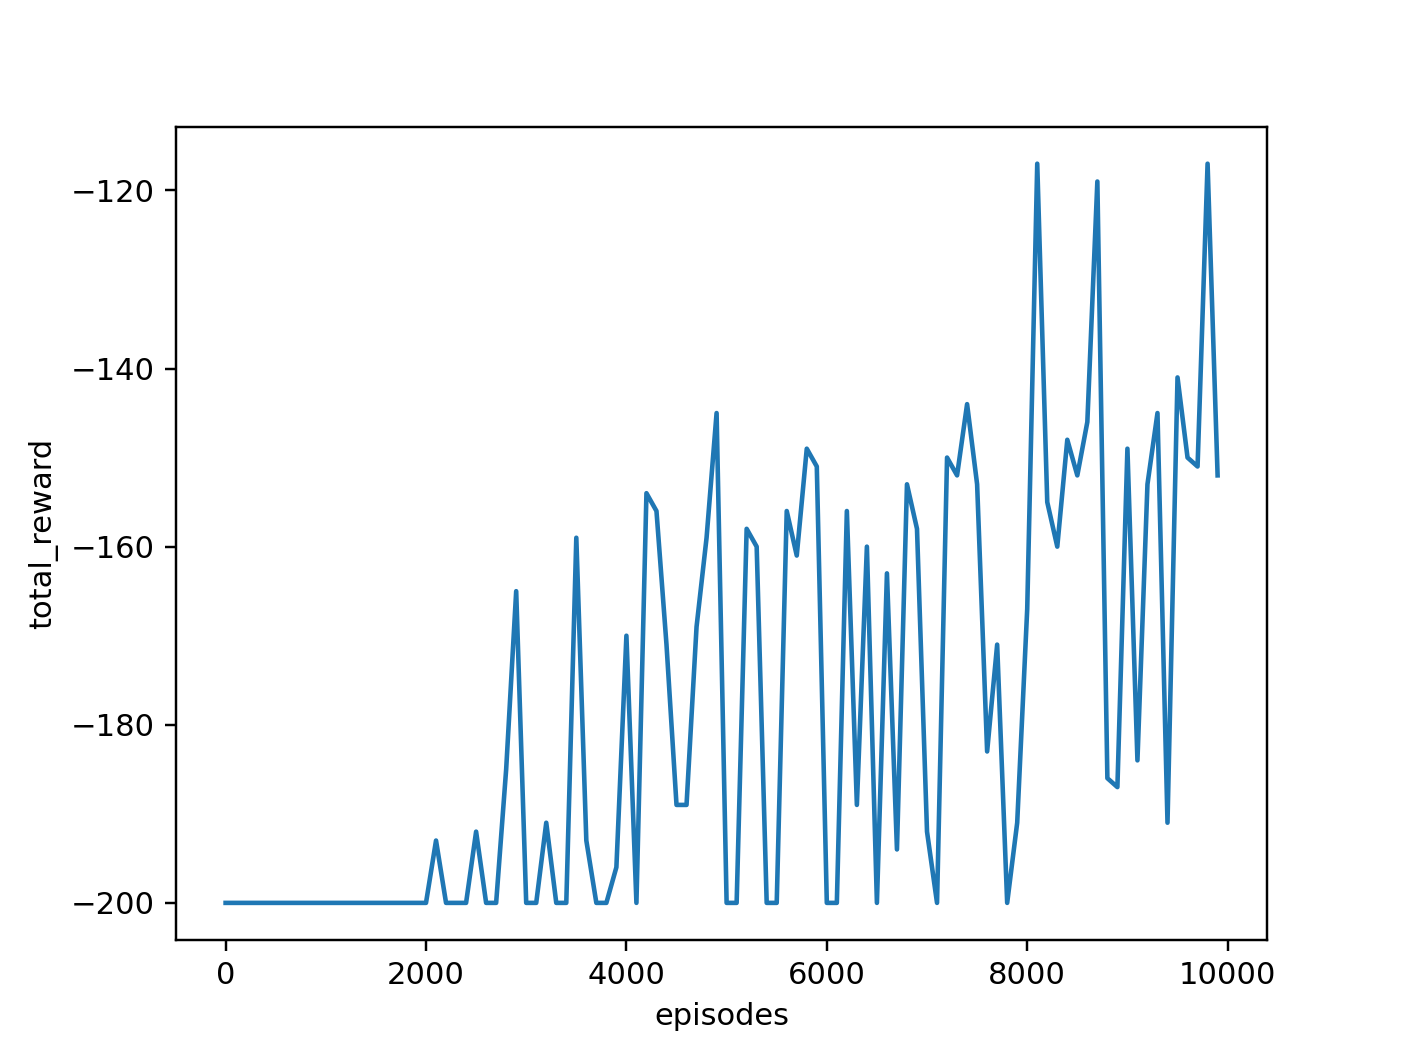

In [68]:
fig = plt.figure()
episodes = np.arange(0,10000,100)
plt.plot(episodes, t_epi_reward)
plt.xlabel("episodes")
plt.ylabel("total_reward")
plt.show()
# plt.xlabel('episodes')#,ylabel='total_reward

- 2000エピソードあたりから報酬が改善始め、安定はしていないがやや右肩上がり。それでも最高で−120程度(200回のうち、80回右の丘に到達)。

In [31]:
observation = env.reset()
frames = []
for episode in range(10000):
    action = get_action(env, q_table, observation, episode)# q_tableは前セルから引き続き
    next_observation, reward, done, _ = env.step(action)
    frames.append(env.render(mode = 'rgb_array'))
    # print(next_observation)
    if reward == 0:
        break

    # Qテーブルの更新
    q_table = update_q_table(q_table, action, observation, next_observation, reward, episode)
    observation = next_observation
        
    if done:
        # doneがTrueになったら１エピソード終了
        if episode%100 == 0:
            print('episode: {}, total_reward: {}'.format(episode, total_reward))
        rewards.append(total_reward)
        break

fig = plt.gcf()
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(fig, animate, frames = len(frames), interval = 50)
plt.show()

<IPython.core.display.Javascript object>


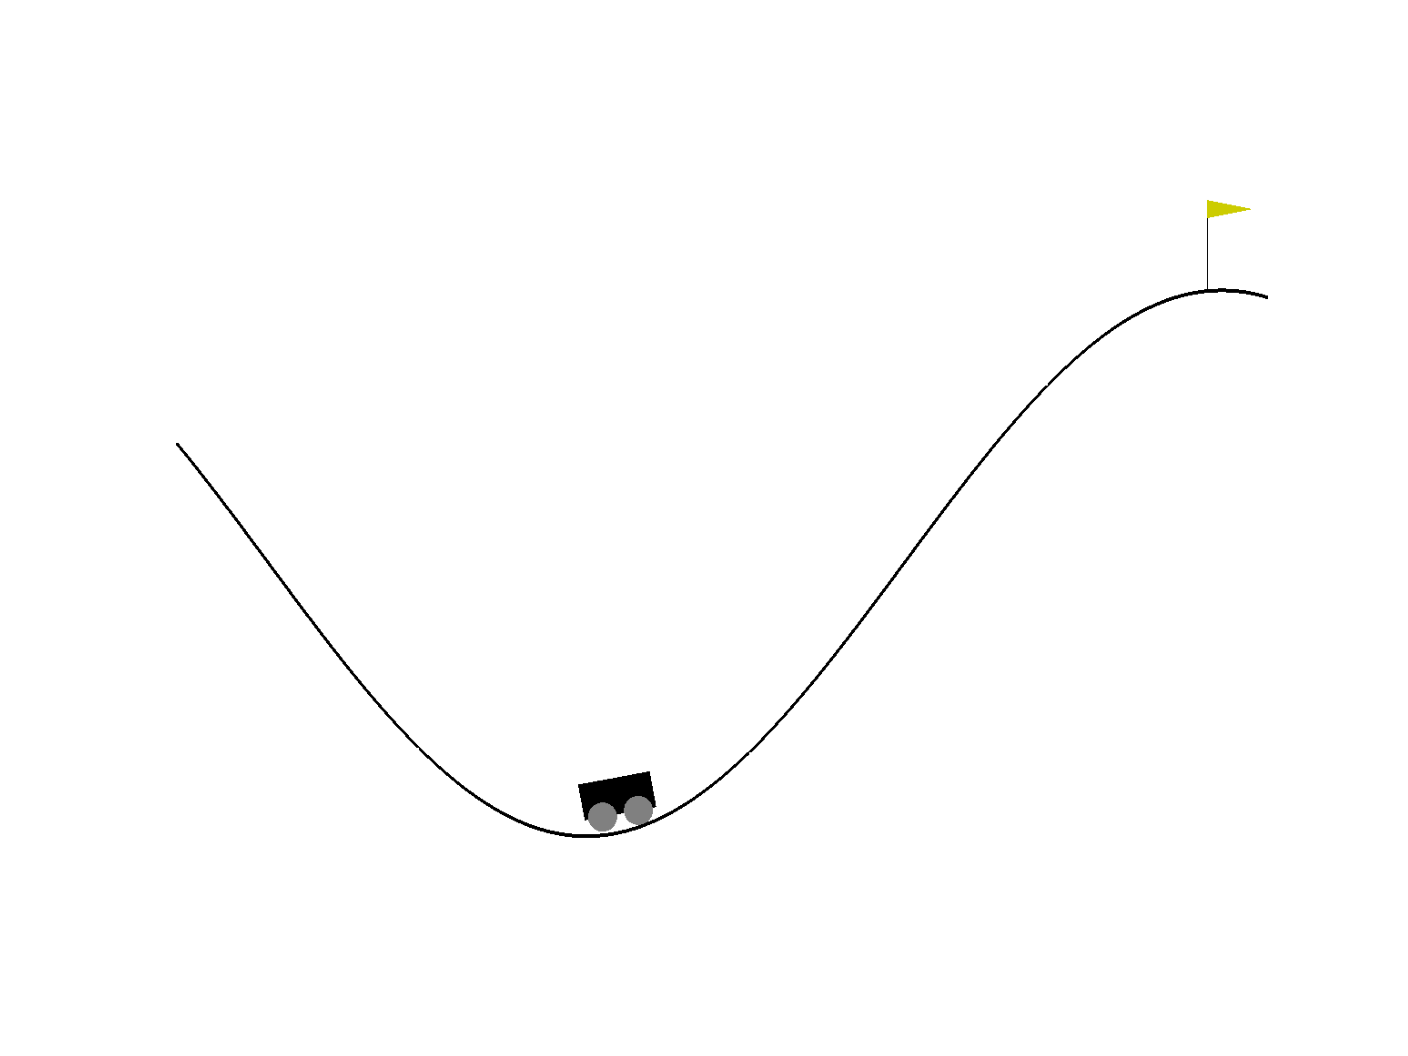

In [27]:
plt.plot(episode,total_reward)

## 2. DQNおよびリプレイメモリの効果検証

- ニューラルネットはdezeroで実装。https://github.com/oreilly-japan/deep-learning-from-scratch-3/tree/master/dezero
- リプレイメモリ = リプレイバッファ
- リプレイメモリなしは、バッチ数 = メモリ数（バッチ数と記憶できる数が一緒）に設定した。
- ニューラルネットの層の数やノード数も変えたパターンも行なった。

In [59]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)# 先入先出法、サイズはbuffer_size
        self.batch_size = batch_size

    # 経験データの追加
    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)
    
    # バッファサイズの確認
    def __len__(self):
        return len(self.buffer)

    # バッファからバッチサイズ分データをサンプリング、np.ndarrayインスタンスに変換
    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])# 縦長データになる
        action = np.array([x[1] for x in data])# 1番目のデータ（行動）が横に並ぶ
        reward = np.array([x[2] for x in data])# 2番目のデータ（報酬）が横に並ぶ
        next_state = np.stack([x[3] for x in data])#  縦長データになる
        done = np.array([x[4] for x in data]).astype(np.int)
        return state, action, reward, next_state, done

In [178]:
import copy
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

class QNet(Model):
    
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(50) #引数は出力数
        self.l2 = L.Linear(50)
        self.l3 = L.Linear(action_size)

    # 順伝播（Relu * Relu * 恒等関数）
    def forward(self, x):
        x = F.relu(self.l1(x)) # 出力数にRelu
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

class DQNAgent:
    def __init__(self):
        self.gamma = 0.99 # 価値関数の割引率
        self.lr = 0.01 # 学習率
        self.epsilon = 0.02 # e-greedyのe
        self.buffer_size = 100000 # バッチサイズと同数だと記憶させない 
        self.batch_size = 32
        self.action_size = 3 # 行動サイズ（課題の行動スペースと一致させる）

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)# ① Q
        self.qnet_target = QNet(self.action_size)# ② Qターゲット（重みはオプティマイザで更新されない）
        self.optimizer = optimizers.Adam(self.lr)# オプティマイザはAdam
        self.optimizer.setup(self.qnet)  # qnetを設定

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)# ② Qターゲットに①を完全コピー

    # ε-greedy
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]  # バッチの次元を追加
            qs = self.qnet(state)
            return qs.data.argmax()
    
    # Q関数の更新
    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)# 経験データの追加
        if len(self.replay_buffer) < self.batch_size: #ミニバッチサイズ以上の経験データが格納されたら、ミニバッチとしてデータを出力
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()# stateは32*2のnp.ndarray, actionは(32,) の形状の np.ndarray, doneは終了したかどうか
        # print(state)
        qs = self.qnet(state)  # ①出力は32*3
        q = qs[np.arange(self.batch_size), action]  # ② ①qsから行動の列 (32)を取り出す
        # print(q)

        next_qs = self.qnet_target(next_state)  # ③
        next_q = next_qs.max(axis=1)# 次の状態におけるQ関数を取り出す（各バッチデータについて最大値）
        next_q.unchain()
        td_target = reward + (1 - done) * self.gamma * next_q  # ④

        loss = F.mean_squared_error(q, td_target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()        

In [136]:
episodes = 10000
sync_interval = 20
env = gym.make('MountainCar-v0')
agent = DQNAgent()
reward_log5 = []
# reward_log, reward_log3: 4層（16ノードの隠れ層）
# reward_log4: 3層（50ノード）
# reward_log5: 3層（50ノード）, リプレイバッファなし

q_table = np.zeros((bins, bins, num_actions))# ゼロ配列に。ランダム配列が良い？

for episode in range(episodes):
    state = env.reset()
    done = False
    sum_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        # next_state, reward, done = step(action)
        # print(episode)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        sum_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_log5.append(sum_reward)
    if episode % 10 == 0:
        print("episode :{}, total reward : {}, epsilon: {}".format(episode, sum_reward, agent.epsilon))

/var/folders/0x/mngd87jd7gs5216gvs0wlw200000gn/T/ipykernel_11142/1861014878.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  done = np.array([x[4] for x in data]).astype(np.int)


episode :0, total reward : -200.0, epsilon: 0.02
episode :10, total reward : -200.0, epsilon: 0.02
episode :20, total reward : -200.0, epsilon: 0.02
episode :30, total reward : -200.0, epsilon: 0.02
episode :40, total reward : -200.0, epsilon: 0.02
episode :50, total reward : -200.0, epsilon: 0.02
episode :60, total reward : -200.0, epsilon: 0.02
episode :70, total reward : -200.0, epsilon: 0.02
episode :80, total reward : -200.0, epsilon: 0.02
episode :90, total reward : -200.0, epsilon: 0.02
episode :100, total reward : -200.0, epsilon: 0.02
episode :110, total reward : -200.0, epsilon: 0.02
episode :120, total reward : -200.0, epsilon: 0.02
episode :130, total reward : -200.0, epsilon: 0.02
episode :140, total reward : -200.0, epsilon: 0.02
episode :150, total reward : -200.0, epsilon: 0.02
episode :160, total reward : -200.0, epsilon: 0.02
episode :170, total reward : -200.0, epsilon: 0.02
episode :180, total reward : -200.0, epsilon: 0.02
episode :190, total reward : -200.0, epsil

episode :1600, total reward : -200.0, epsilon: 0.02
episode :1610, total reward : -200.0, epsilon: 0.02
episode :1620, total reward : -200.0, epsilon: 0.02
episode :1630, total reward : -200.0, epsilon: 0.02
episode :1640, total reward : -200.0, epsilon: 0.02
episode :1650, total reward : -200.0, epsilon: 0.02
episode :1660, total reward : -200.0, epsilon: 0.02
episode :1670, total reward : -200.0, epsilon: 0.02
episode :1680, total reward : -200.0, epsilon: 0.02
episode :1690, total reward : -200.0, epsilon: 0.02
episode :1700, total reward : -200.0, epsilon: 0.02
episode :1710, total reward : -200.0, epsilon: 0.02
episode :1720, total reward : -200.0, epsilon: 0.02
episode :1730, total reward : -170.0, epsilon: 0.02
episode :1740, total reward : -200.0, epsilon: 0.02
episode :1750, total reward : -200.0, epsilon: 0.02
episode :1760, total reward : -200.0, epsilon: 0.02
episode :1770, total reward : -200.0, epsilon: 0.02
episode :1780, total reward : -200.0, epsilon: 0.02
episode :179

episode :3180, total reward : -200.0, epsilon: 0.02
episode :3190, total reward : -200.0, epsilon: 0.02
episode :3200, total reward : -200.0, epsilon: 0.02
episode :3210, total reward : -200.0, epsilon: 0.02
episode :3220, total reward : -200.0, epsilon: 0.02
episode :3230, total reward : -200.0, epsilon: 0.02
episode :3240, total reward : -200.0, epsilon: 0.02
episode :3250, total reward : -200.0, epsilon: 0.02
episode :3260, total reward : -200.0, epsilon: 0.02
episode :3270, total reward : -200.0, epsilon: 0.02
episode :3280, total reward : -200.0, epsilon: 0.02
episode :3290, total reward : -200.0, epsilon: 0.02
episode :3300, total reward : -200.0, epsilon: 0.02
episode :3310, total reward : -200.0, epsilon: 0.02
episode :3320, total reward : -200.0, epsilon: 0.02
episode :3330, total reward : -200.0, epsilon: 0.02
episode :3340, total reward : -200.0, epsilon: 0.02
episode :3350, total reward : -200.0, epsilon: 0.02
episode :3360, total reward : -200.0, epsilon: 0.02
episode :337

episode :4760, total reward : -200.0, epsilon: 0.02
episode :4770, total reward : -200.0, epsilon: 0.02
episode :4780, total reward : -200.0, epsilon: 0.02
episode :4790, total reward : -200.0, epsilon: 0.02
episode :4800, total reward : -200.0, epsilon: 0.02
episode :4810, total reward : -200.0, epsilon: 0.02
episode :4820, total reward : -200.0, epsilon: 0.02
episode :4830, total reward : -200.0, epsilon: 0.02
episode :4840, total reward : -200.0, epsilon: 0.02
episode :4850, total reward : -200.0, epsilon: 0.02
episode :4860, total reward : -200.0, epsilon: 0.02
episode :4870, total reward : -200.0, epsilon: 0.02
episode :4880, total reward : -200.0, epsilon: 0.02
episode :4890, total reward : -200.0, epsilon: 0.02
episode :4900, total reward : -200.0, epsilon: 0.02
episode :4910, total reward : -200.0, epsilon: 0.02
episode :4920, total reward : -200.0, epsilon: 0.02
episode :4930, total reward : -200.0, epsilon: 0.02
episode :4940, total reward : -200.0, epsilon: 0.02
episode :495

episode :6340, total reward : -200.0, epsilon: 0.02
episode :6350, total reward : -200.0, epsilon: 0.02
episode :6360, total reward : -200.0, epsilon: 0.02
episode :6370, total reward : -200.0, epsilon: 0.02
episode :6380, total reward : -200.0, epsilon: 0.02
episode :6390, total reward : -200.0, epsilon: 0.02
episode :6400, total reward : -200.0, epsilon: 0.02
episode :6410, total reward : -200.0, epsilon: 0.02
episode :6420, total reward : -200.0, epsilon: 0.02
episode :6430, total reward : -200.0, epsilon: 0.02
episode :6440, total reward : -200.0, epsilon: 0.02
episode :6450, total reward : -200.0, epsilon: 0.02
episode :6460, total reward : -200.0, epsilon: 0.02
episode :6470, total reward : -200.0, epsilon: 0.02
episode :6480, total reward : -200.0, epsilon: 0.02
episode :6490, total reward : -200.0, epsilon: 0.02
episode :6500, total reward : -200.0, epsilon: 0.02
episode :6510, total reward : -200.0, epsilon: 0.02
episode :6520, total reward : -200.0, epsilon: 0.02
episode :653

episode :7920, total reward : -200.0, epsilon: 0.02
episode :7930, total reward : -200.0, epsilon: 0.02
episode :7940, total reward : -200.0, epsilon: 0.02
episode :7950, total reward : -200.0, epsilon: 0.02
episode :7960, total reward : -200.0, epsilon: 0.02
episode :7970, total reward : -200.0, epsilon: 0.02
episode :7980, total reward : -200.0, epsilon: 0.02
episode :7990, total reward : -200.0, epsilon: 0.02
episode :8000, total reward : -200.0, epsilon: 0.02
episode :8010, total reward : -200.0, epsilon: 0.02
episode :8020, total reward : -200.0, epsilon: 0.02
episode :8030, total reward : -200.0, epsilon: 0.02
episode :8040, total reward : -200.0, epsilon: 0.02
episode :8050, total reward : -200.0, epsilon: 0.02
episode :8060, total reward : -200.0, epsilon: 0.02
episode :8070, total reward : -200.0, epsilon: 0.02
episode :8080, total reward : -200.0, epsilon: 0.02
episode :8090, total reward : -200.0, epsilon: 0.02
episode :8100, total reward : -200.0, epsilon: 0.02
episode :811

episode :9500, total reward : -200.0, epsilon: 0.02
episode :9510, total reward : -200.0, epsilon: 0.02
episode :9520, total reward : -200.0, epsilon: 0.02
episode :9530, total reward : -200.0, epsilon: 0.02
episode :9540, total reward : -200.0, epsilon: 0.02
episode :9550, total reward : -200.0, epsilon: 0.02
episode :9560, total reward : -200.0, epsilon: 0.02
episode :9570, total reward : -200.0, epsilon: 0.02
episode :9580, total reward : -200.0, epsilon: 0.02
episode :9590, total reward : -200.0, epsilon: 0.02
episode :9600, total reward : -200.0, epsilon: 0.02
episode :9610, total reward : -200.0, epsilon: 0.02
episode :9620, total reward : -200.0, epsilon: 0.02
episode :9630, total reward : -200.0, epsilon: 0.02
episode :9640, total reward : -200.0, epsilon: 0.02
episode :9650, total reward : -200.0, epsilon: 0.02
episode :9660, total reward : -200.0, epsilon: 0.02
episode :9670, total reward : -200.0, epsilon: 0.02
episode :9680, total reward : -200.0, epsilon: 0.02
episode :969

<IPython.core.display.Javascript object>


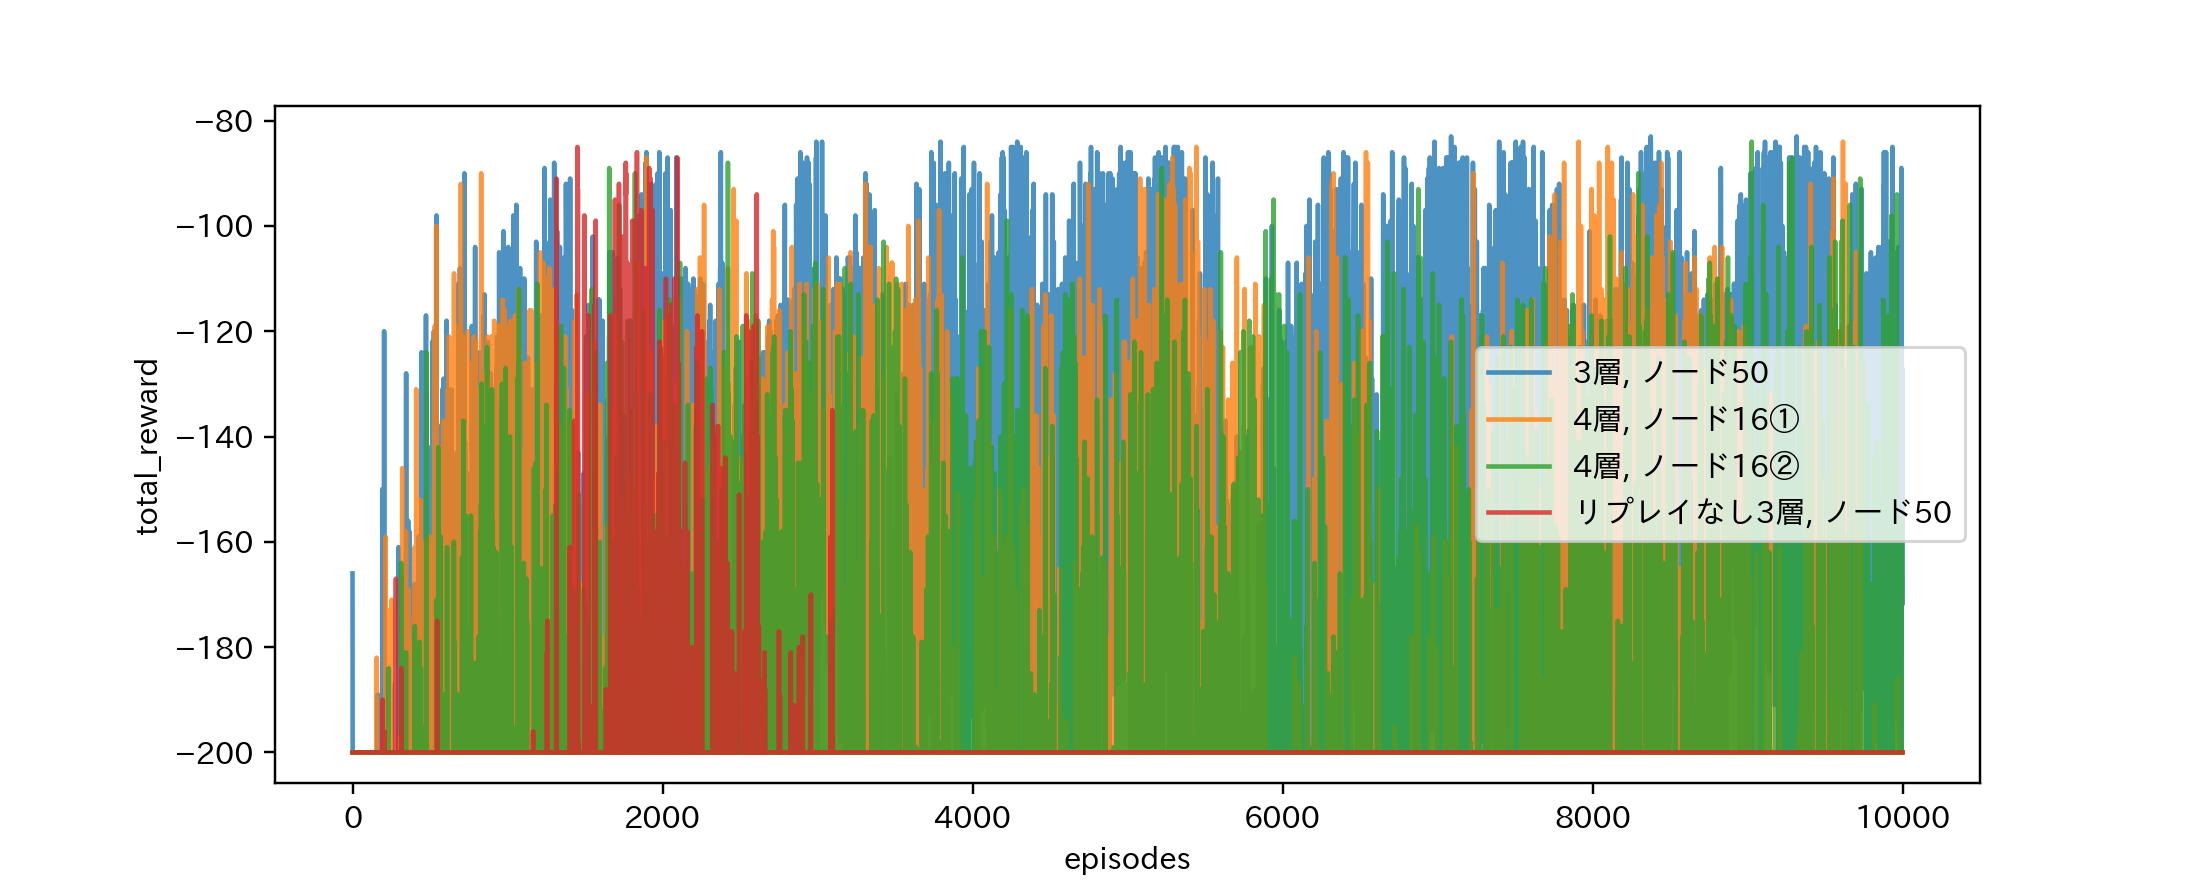

In [152]:
fig = plt.figure(figsize=(10,4))
episodes = np.arange(0,10000)
plt.plot(episodes, reward_log4, alpha=0.8, label="3層, ノード50")
plt.plot(episodes, reward_log, alpha=0.8, label="4層, ノード16①")
plt.plot(episodes, reward_log3, alpha=0.8, label="4層, ノード16②")
plt.plot(episodes, reward_log5, alpha=0.8, label="リプレイなし3層, ノード50")


plt.xlabel("episodes")
plt.ylabel("total_reward")
plt.legend(loc='center right',)
plt.show()

- リプレイメモリなし（上記の赤線グラフ）は、学習が全く安定しなかった。
- リプレイメモリがあると、通常のQラーニングに比べ早くパフォーマンスが改善した。ただし、スコアは-100程度までいくがそこで頭打ちであり、リプレイメモリ無しに比べたら安定しているものの、パフォーマンスの波も見られた。全ての経験を記憶するのではなく、重要度の高い経験のみ記憶できれば、よりパフォーマンスは上がると思われる。
- パラメータは詳細に検討していないが、4層で隠れ層ノード16よりも、3層で隠れ層ノード50の方がパフォーマンスは良かった。

## 3. 報酬の定義変更

- 「MountainCar」は報酬の設定上学習が難しい、という内容の記事を見たため、報酬の定義を変更してみた。
- 変更前： -1.2 ~ 0.6 の値をとる車の位置が0.5以上だと0、それ以外だと-1
- 変更後： 車の位置が0.5以上だと1, それ以外だと車の位置+0.5
 - 参考　https://www.renom.jp/ja/notebooks/product/renom_rl/ddqn/notebook.html

In [105]:
episodes = 10000
sync_interval = 20
env = gym.make('MountainCar-v0')
agent = DQNAgent()
reward_log2 = []

# 報酬の定義を変更
def step(action):
    state, _, terminal, _ = env.step(int(action))
    reward = 0
    if terminal:
        if state[0] > 0.5:
            reward = 1
        else:
            reward = state[0] + 0.5
    return state, reward, terminal

for episode in range(episodes):
    state = env.reset()
    done = False
    sum_reward = 0

    while not done:
        action = agent.get_action(state)
         # next_state, reward, done, info = env.step(action)
        next_state, reward, done = step(action)

        agent.update(state, action, reward, next_state, done)
        state = next_state
        sum_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_log2.append(sum_reward)
    if episode % 10 == 0:
        print("episode :{}, total reward : {}, epsilon: {}".format(episode, sum_reward, agent.epsilon))

/var/folders/0x/mngd87jd7gs5216gvs0wlw200000gn/T/ipykernel_11142/1861014878.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  done = np.array([x[4] for x in data]).astype(np.int)


episode :0, total reward : -0.028766214847564697, epsilon: 0.02
episode :10, total reward : -0.1178520917892456, epsilon: 0.02
episode :20, total reward : 0.653668001294136, epsilon: 0.02
episode :30, total reward : -0.34381943941116333, epsilon: 0.02
episode :40, total reward : 0.05788278579711914, epsilon: 0.02
episode :50, total reward : -0.30256742238998413, epsilon: 0.02
episode :60, total reward : -0.17471766471862793, epsilon: 0.02
episode :70, total reward : 0.05819582939147949, epsilon: 0.02
episode :80, total reward : -0.33249443769454956, epsilon: 0.02
episode :90, total reward : -0.404361367225647, epsilon: 0.02
episode :100, total reward : -0.0011001229286193848, epsilon: 0.02
episode :110, total reward : -0.53045654296875, epsilon: 0.02
episode :120, total reward : -0.24559205770492554, epsilon: 0.02
episode :130, total reward : -0.09807693958282471, epsilon: 0.02
episode :140, total reward : 0.014954626560211182, epsilon: 0.02
episode :150, total reward : -0.011378049850

episode :1270, total reward : -0.30739182233810425, epsilon: 0.02
episode :1280, total reward : 0.1013561487197876, epsilon: 0.02
episode :1290, total reward : -0.03490936756134033, epsilon: 0.02
episode :1300, total reward : 0.2705303132534027, epsilon: 0.02
episode :1310, total reward : 0.02123260498046875, epsilon: 0.02
episode :1320, total reward : 0.01956292986869812, epsilon: 0.02
episode :1330, total reward : -0.14946281909942627, epsilon: 0.02
episode :1340, total reward : -0.09195244312286377, epsilon: 0.02
episode :1350, total reward : 0.09542930126190186, epsilon: 0.02
episode :1360, total reward : 0.11549919843673706, epsilon: 0.02
episode :1370, total reward : 0.2659798711538315, epsilon: 0.02
episode :1380, total reward : -0.03679251670837402, epsilon: 0.02
episode :1390, total reward : 0.10286536812782288, epsilon: 0.02
episode :1400, total reward : -0.01898801326751709, epsilon: 0.02
episode :1410, total reward : -0.07382529973983765, epsilon: 0.02
episode :1420, total 

episode :2520, total reward : -0.07870864868164062, epsilon: 0.02
episode :2530, total reward : 0.09038242697715759, epsilon: 0.02
episode :2540, total reward : -0.09601843357086182, epsilon: 0.02
episode :2550, total reward : 0.1831909418106079, epsilon: 0.02
episode :2560, total reward : -0.11833173036575317, epsilon: 0.02
episode :2570, total reward : -0.022935986518859863, epsilon: 0.02
episode :2580, total reward : -0.2435649037361145, epsilon: 0.02
episode :2590, total reward : 0.023043423891067505, epsilon: 0.02
episode :2600, total reward : -0.06602925062179565, epsilon: 0.02
episode :2610, total reward : -0.12099766731262207, epsilon: 0.02
episode :2620, total reward : 0.029919564723968506, epsilon: 0.02
episode :2630, total reward : -0.0780821442604065, epsilon: 0.02
episode :2640, total reward : 0.06506136059761047, epsilon: 0.02
episode :2650, total reward : -0.026751816272735596, epsilon: 0.02
episode :2660, total reward : -0.07126832008361816, epsilon: 0.02
episode :2670,

episode :3770, total reward : -0.11855632066726685, epsilon: 0.02
episode :3780, total reward : -0.043115973472595215, epsilon: 0.02
episode :3790, total reward : -0.08069723844528198, epsilon: 0.02
episode :3800, total reward : -0.07939499616622925, epsilon: 0.02
episode :3810, total reward : -0.02858787775039673, epsilon: 0.02
episode :3820, total reward : 0.06493663787841797, epsilon: 0.02
episode :3830, total reward : -0.1716325879096985, epsilon: 0.02
episode :3840, total reward : 0.0326097309589386, epsilon: 0.02
episode :3850, total reward : -0.026790916919708252, epsilon: 0.02
episode :3860, total reward : -0.039340198040008545, epsilon: 0.02
episode :3870, total reward : -0.010969817638397217, epsilon: 0.02
episode :3880, total reward : -0.056817471981048584, epsilon: 0.02
episode :3890, total reward : 0.05129396915435791, epsilon: 0.02
episode :3900, total reward : 0.21792051196098328, epsilon: 0.02
episode :3910, total reward : -0.18400269746780396, epsilon: 0.02
episode :39

episode :5020, total reward : 0.01991182565689087, epsilon: 0.02
episode :5030, total reward : 0.018768668174743652, epsilon: 0.02
episode :5040, total reward : -0.004194319248199463, epsilon: 0.02
episode :5050, total reward : 0.04348227381706238, epsilon: 0.02
episode :5060, total reward : -0.3107512593269348, epsilon: 0.02
episode :5070, total reward : 0.012322098016738892, epsilon: 0.02
episode :5080, total reward : -0.1024659276008606, epsilon: 0.02
episode :5090, total reward : 0.2499263882637024, epsilon: 0.02
episode :5100, total reward : -0.07911258935928345, epsilon: 0.02
episode :5110, total reward : 0.16163131594657898, epsilon: 0.02
episode :5120, total reward : 0.10694652795791626, epsilon: 0.02
episode :5130, total reward : -0.1367219090461731, epsilon: 0.02
episode :5140, total reward : -0.07910120487213135, epsilon: 0.02
episode :5150, total reward : -0.0176658034324646, epsilon: 0.02
episode :5160, total reward : 0.025180131196975708, epsilon: 0.02
episode :5170, tota

episode :6270, total reward : 0.07176172733306885, epsilon: 0.02
episode :6280, total reward : -0.14846676588058472, epsilon: 0.02
episode :6290, total reward : 0.048104166984558105, epsilon: 0.02
episode :6300, total reward : -0.15916818380355835, epsilon: 0.02
episode :6310, total reward : -0.10850393772125244, epsilon: 0.02
episode :6320, total reward : 0.08263275027275085, epsilon: 0.02
episode :6330, total reward : -0.1289304494857788, epsilon: 0.02
episode :6340, total reward : -0.1032557487487793, epsilon: 0.02
episode :6350, total reward : -0.03606027364730835, epsilon: 0.02
episode :6360, total reward : -0.2371615767478943, epsilon: 0.02
episode :6370, total reward : -0.24563246965408325, epsilon: 0.02
episode :6380, total reward : 0.11334976553916931, epsilon: 0.02
episode :6390, total reward : -0.019562602043151855, epsilon: 0.02
episode :6400, total reward : -0.2118760347366333, epsilon: 0.02
episode :6410, total reward : -0.10866612195968628, epsilon: 0.02
episode :6420, t

episode :7520, total reward : -0.06284970045089722, epsilon: 0.02
episode :7530, total reward : 0.0044175684452056885, epsilon: 0.02
episode :7540, total reward : -0.025065243244171143, epsilon: 0.02
episode :7550, total reward : 0.03908625245094299, epsilon: 0.02
episode :7560, total reward : -0.0923653244972229, epsilon: 0.02
episode :7570, total reward : -0.07370871305465698, epsilon: 0.02
episode :7580, total reward : -0.13850152492523193, epsilon: 0.02
episode :7590, total reward : 0.1428280472755432, epsilon: 0.02
episode :7600, total reward : -0.009672045707702637, epsilon: 0.02
episode :7610, total reward : -0.12758684158325195, epsilon: 0.02
episode :7620, total reward : 0.07412227988243103, epsilon: 0.02
episode :7630, total reward : -0.10918784141540527, epsilon: 0.02
episode :7640, total reward : 0.006476342678070068, epsilon: 0.02
episode :7650, total reward : 0.07735362648963928, epsilon: 0.02
episode :7660, total reward : -0.15997976064682007, epsilon: 0.02
episode :7670

episode :8770, total reward : -0.1090894341468811, epsilon: 0.02
episode :8780, total reward : -0.1633824110031128, epsilon: 0.02
episode :8790, total reward : 0.2090063989162445, epsilon: 0.02
episode :8800, total reward : -0.1151396632194519, epsilon: 0.02
episode :8810, total reward : -0.05587339401245117, epsilon: 0.02
episode :8820, total reward : -0.011272072792053223, epsilon: 0.02
episode :8830, total reward : -0.18062156438827515, epsilon: 0.02
episode :8840, total reward : -0.013033270835876465, epsilon: 0.02
episode :8850, total reward : 0.03841853141784668, epsilon: 0.02
episode :8860, total reward : -0.10348242521286011, epsilon: 0.02
episode :8870, total reward : 0.10843300819396973, epsilon: 0.02
episode :8880, total reward : -0.036585211753845215, epsilon: 0.02
episode :8890, total reward : -0.1413116455078125, epsilon: 0.02
episode :8900, total reward : -0.033860862255096436, epsilon: 0.02
episode :8910, total reward : 0.23895978927612305, epsilon: 0.02
episode :8920, 

<IPython.core.display.Javascript object>


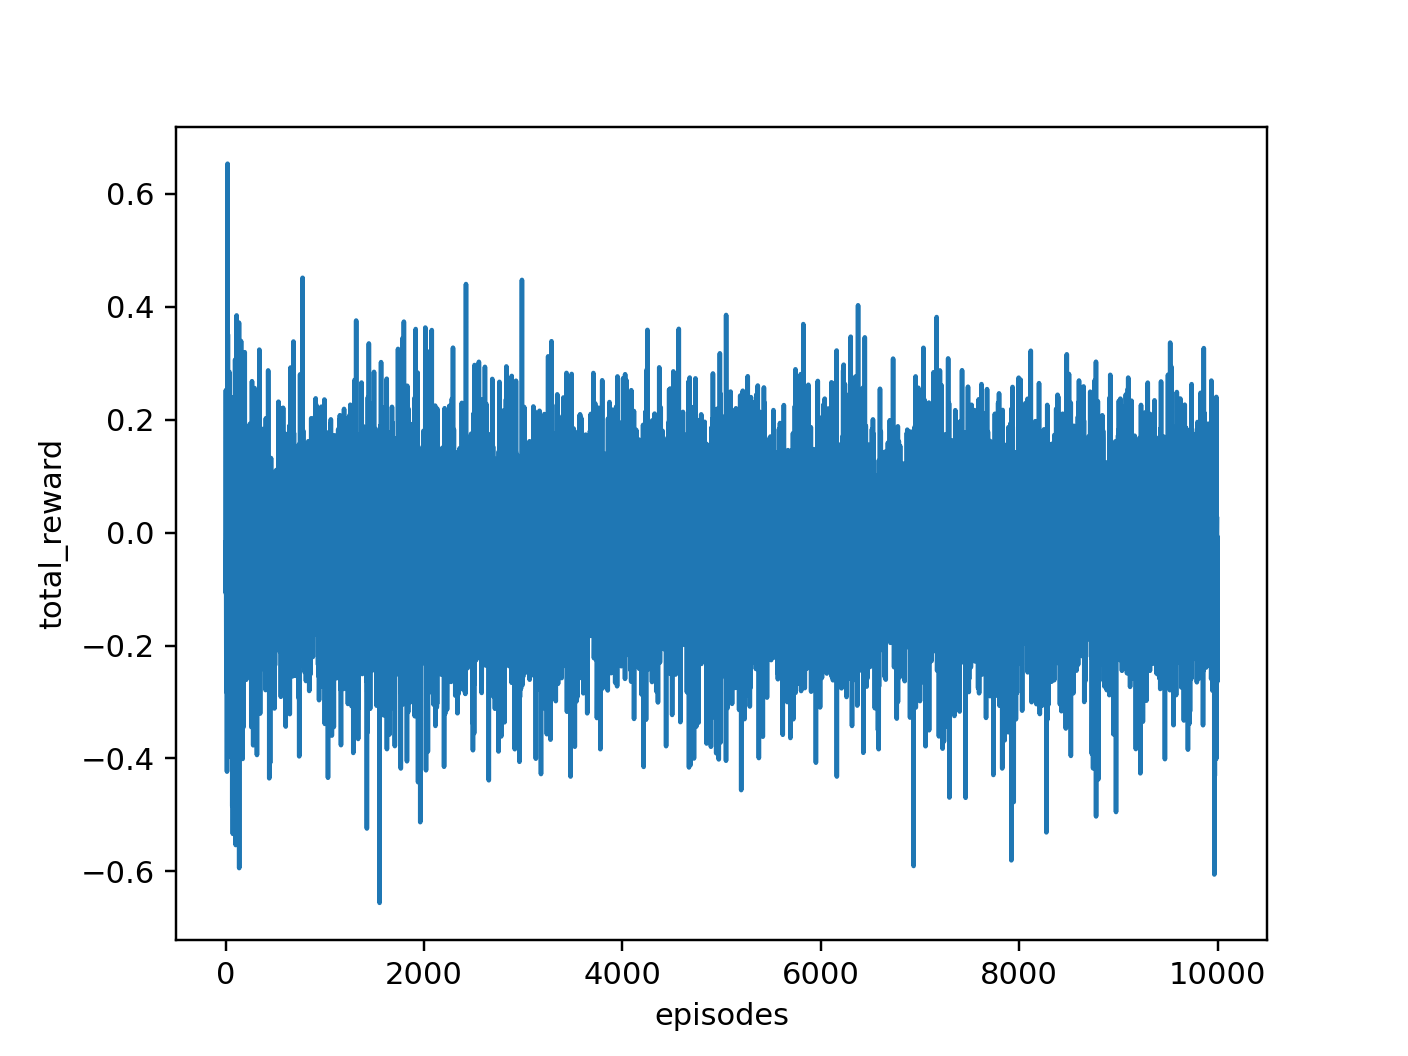

In [106]:
fig = plt.figure()
episodes = np.arange(0,10000)
plt.plot(episodes, reward_log2)
plt.xlabel("episodes")
plt.ylabel("total_reward")
plt.show()

- パフォーマンスに改善は見られなかった。
- 検証はしていないが、車の位置を単純に報酬としてしまうと弊害があるのではないかと考えた。すなわち、右上に登るためには左に移動し助走をつける必要があるが、左側だと車の位置がマイナスであり、この報酬の設定だと左に行く行動を避けるように学習するのではないだろうか。

## 4. Double DQNの実装
- 参考　https://schemer1341.hatenablog.com/entry/2019/09/11/225436

In [179]:
class DDQNAgent:
    def __init__(self):
        self.gamma = 0.99 # 価値関数の割引率
        self.lr = 0.01 # 学習率
        self.epsilon = 0.02 # e-greedyのe
        self.buffer_size = 100000 
        self.batch_size = 32
        self.action_size = 3 # 行動サイズ（課題の行動スペースと一致させる）

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)# ① Q
        self.qnet_target = QNet(self.action_size)# ② Qターゲット（重みはオプティマイザで更新されない）
        self.optimizer = optimizers.Adam(self.lr)# オプティマイザはAdam
        self.optimizer.setup(self.qnet)  # qnetを設定

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)# ② Qターゲットに①を完全コピー

    # ε-greedy
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]  # バッチの次元を追加
            qs = self.qnet(state)
            return qs.data.argmax()
    
    # Q関数の更新
    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)# 経験データの追加
        if len(self.replay_buffer) < self.batch_size: #ミニバッチサイズ以上の経験データが格納されたら、ミニバッチとしてデータを出力
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()# stateは32*4のnp.ndarray, actionは(32,) の形状の np.ndarray, doneは終了したかどうか
        qs = self.qnet(state)  # ①出力は32*2
        q = qs[np.arange(self.batch_size), action]  # ② ①qsから行動を取り出す

#         next_qs = self.qnet_target(next_state)  # ③
#         print("next_qs =", next_qs)#32 *3
#         next_q = next_qs.max(axis=1)
#         print("next_q =", next_q)#32 *1

        # ① Qから最大となるindexを得る
        next_qs = self.qnet(next_state) 
        idx = np.argmax(next_qs.data, axis = 1) # (1*32)
        # print(state)# (32*2)
        # print(self.qnet_target(next_state))#(32*3)
        
        # 上記indexを使って② Qターゲットでの値を得る
        next_q = self.qnet_target(next_state)[:,idx[0]]# idxはどの行も同じ値であったため、0行目で統一した。
        next_q.unchain()
        td_target = reward + (1 - done) * self.gamma * next_q  # ④

#         next_qs = self.qnet_target(next_state)  # ③
#         next_q = next_qs.max(axis=1)# 次の状態におけるQ関数を取り出す（各バッチデータについて最大値）
#         next_q.unchain()
#         td_target = reward + (1 - done) * self.gamma * next_q  # ④

        loss = F.mean_squared_error(q, td_target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

In [180]:
episodes = 10000
sync_interval = 20
env = gym.make('MountainCar-v0')
agent = DDQNAgent()
reward_log_dd = []

for episode in range(episodes):
    state = env.reset()
    done = False
    sum_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        # next_state, reward, done = step(action)

        agent.update(state, action, reward, next_state, done)
        state = next_state
        sum_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_log_dd.append(sum_reward)
    if episode % 10 == 0:
        print("episode :{}, total reward : {}, epsilon: {}".format(episode, sum_reward, agent.epsilon))

/var/folders/0x/mngd87jd7gs5216gvs0wlw200000gn/T/ipykernel_11142/1861014878.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  done = np.array([x[4] for x in data]).astype(np.int)


episode :0, total reward : -200.0, epsilon: 0.02
episode :10, total reward : -200.0, epsilon: 0.02
episode :20, total reward : -200.0, epsilon: 0.02
episode :30, total reward : -200.0, epsilon: 0.02
episode :40, total reward : -200.0, epsilon: 0.02
episode :50, total reward : -200.0, epsilon: 0.02
episode :60, total reward : -200.0, epsilon: 0.02
episode :70, total reward : -200.0, epsilon: 0.02
episode :80, total reward : -200.0, epsilon: 0.02
episode :90, total reward : -200.0, epsilon: 0.02
episode :100, total reward : -200.0, epsilon: 0.02
episode :110, total reward : -200.0, epsilon: 0.02
episode :120, total reward : -200.0, epsilon: 0.02
episode :130, total reward : -200.0, epsilon: 0.02
episode :140, total reward : -200.0, epsilon: 0.02
episode :150, total reward : -200.0, epsilon: 0.02
episode :160, total reward : -200.0, epsilon: 0.02
episode :170, total reward : -200.0, epsilon: 0.02
episode :180, total reward : -200.0, epsilon: 0.02
episode :190, total reward : -200.0, epsil

episode :1600, total reward : -144.0, epsilon: 0.02
episode :1610, total reward : -200.0, epsilon: 0.02
episode :1620, total reward : -200.0, epsilon: 0.02
episode :1630, total reward : -200.0, epsilon: 0.02
episode :1640, total reward : -137.0, epsilon: 0.02
episode :1650, total reward : -200.0, epsilon: 0.02
episode :1660, total reward : -200.0, epsilon: 0.02
episode :1670, total reward : -200.0, epsilon: 0.02
episode :1680, total reward : -200.0, epsilon: 0.02
episode :1690, total reward : -200.0, epsilon: 0.02
episode :1700, total reward : -200.0, epsilon: 0.02
episode :1710, total reward : -200.0, epsilon: 0.02
episode :1720, total reward : -179.0, epsilon: 0.02
episode :1730, total reward : -200.0, epsilon: 0.02
episode :1740, total reward : -200.0, epsilon: 0.02
episode :1750, total reward : -199.0, epsilon: 0.02
episode :1760, total reward : -162.0, epsilon: 0.02
episode :1770, total reward : -200.0, epsilon: 0.02
episode :1780, total reward : -189.0, epsilon: 0.02
episode :179

episode :3180, total reward : -169.0, epsilon: 0.02
episode :3190, total reward : -162.0, epsilon: 0.02
episode :3200, total reward : -155.0, epsilon: 0.02
episode :3210, total reward : -200.0, epsilon: 0.02
episode :3220, total reward : -121.0, epsilon: 0.02
episode :3230, total reward : -158.0, epsilon: 0.02
episode :3240, total reward : -158.0, epsilon: 0.02
episode :3250, total reward : -173.0, epsilon: 0.02
episode :3260, total reward : -176.0, epsilon: 0.02
episode :3270, total reward : -200.0, epsilon: 0.02
episode :3280, total reward : -172.0, epsilon: 0.02
episode :3290, total reward : -200.0, epsilon: 0.02
episode :3300, total reward : -142.0, epsilon: 0.02
episode :3310, total reward : -166.0, epsilon: 0.02
episode :3320, total reward : -200.0, epsilon: 0.02
episode :3330, total reward : -166.0, epsilon: 0.02
episode :3340, total reward : -172.0, epsilon: 0.02
episode :3350, total reward : -175.0, epsilon: 0.02
episode :3360, total reward : -162.0, epsilon: 0.02
episode :337

episode :4760, total reward : -166.0, epsilon: 0.02
episode :4770, total reward : -156.0, epsilon: 0.02
episode :4780, total reward : -164.0, epsilon: 0.02
episode :4790, total reward : -161.0, epsilon: 0.02
episode :4800, total reward : -194.0, epsilon: 0.02
episode :4810, total reward : -200.0, epsilon: 0.02
episode :4820, total reward : -156.0, epsilon: 0.02
episode :4830, total reward : -149.0, epsilon: 0.02
episode :4840, total reward : -152.0, epsilon: 0.02
episode :4850, total reward : -200.0, epsilon: 0.02
episode :4860, total reward : -186.0, epsilon: 0.02
episode :4870, total reward : -85.0, epsilon: 0.02
episode :4880, total reward : -151.0, epsilon: 0.02
episode :4890, total reward : -200.0, epsilon: 0.02
episode :4900, total reward : -163.0, epsilon: 0.02
episode :4910, total reward : -165.0, epsilon: 0.02
episode :4920, total reward : -200.0, epsilon: 0.02
episode :4930, total reward : -200.0, epsilon: 0.02
episode :4940, total reward : -200.0, epsilon: 0.02
episode :4950

episode :6340, total reward : -92.0, epsilon: 0.02
episode :6350, total reward : -200.0, epsilon: 0.02
episode :6360, total reward : -129.0, epsilon: 0.02
episode :6370, total reward : -148.0, epsilon: 0.02
episode :6380, total reward : -161.0, epsilon: 0.02
episode :6390, total reward : -139.0, epsilon: 0.02
episode :6400, total reward : -141.0, epsilon: 0.02
episode :6410, total reward : -200.0, epsilon: 0.02
episode :6420, total reward : -159.0, epsilon: 0.02
episode :6430, total reward : -122.0, epsilon: 0.02
episode :6440, total reward : -200.0, epsilon: 0.02
episode :6450, total reward : -154.0, epsilon: 0.02
episode :6460, total reward : -126.0, epsilon: 0.02
episode :6470, total reward : -111.0, epsilon: 0.02
episode :6480, total reward : -126.0, epsilon: 0.02
episode :6490, total reward : -127.0, epsilon: 0.02
episode :6500, total reward : -125.0, epsilon: 0.02
episode :6510, total reward : -118.0, epsilon: 0.02
episode :6520, total reward : -200.0, epsilon: 0.02
episode :6530

episode :7920, total reward : -200.0, epsilon: 0.02
episode :7930, total reward : -173.0, epsilon: 0.02
episode :7940, total reward : -172.0, epsilon: 0.02
episode :7950, total reward : -200.0, epsilon: 0.02
episode :7960, total reward : -177.0, epsilon: 0.02
episode :7970, total reward : -181.0, epsilon: 0.02
episode :7980, total reward : -200.0, epsilon: 0.02
episode :7990, total reward : -200.0, epsilon: 0.02
episode :8000, total reward : -200.0, epsilon: 0.02
episode :8010, total reward : -129.0, epsilon: 0.02
episode :8020, total reward : -200.0, epsilon: 0.02
episode :8030, total reward : -200.0, epsilon: 0.02
episode :8040, total reward : -198.0, epsilon: 0.02
episode :8050, total reward : -199.0, epsilon: 0.02
episode :8060, total reward : -200.0, epsilon: 0.02
episode :8070, total reward : -200.0, epsilon: 0.02
episode :8080, total reward : -199.0, epsilon: 0.02
episode :8090, total reward : -172.0, epsilon: 0.02
episode :8100, total reward : -200.0, epsilon: 0.02
episode :811

episode :9500, total reward : -176.0, epsilon: 0.02
episode :9510, total reward : -200.0, epsilon: 0.02
episode :9520, total reward : -200.0, epsilon: 0.02
episode :9530, total reward : -200.0, epsilon: 0.02
episode :9540, total reward : -200.0, epsilon: 0.02
episode :9550, total reward : -200.0, epsilon: 0.02
episode :9560, total reward : -200.0, epsilon: 0.02
episode :9570, total reward : -200.0, epsilon: 0.02
episode :9580, total reward : -191.0, epsilon: 0.02
episode :9590, total reward : -168.0, epsilon: 0.02
episode :9600, total reward : -200.0, epsilon: 0.02
episode :9610, total reward : -200.0, epsilon: 0.02
episode :9620, total reward : -200.0, epsilon: 0.02
episode :9630, total reward : -200.0, epsilon: 0.02
episode :9640, total reward : -169.0, epsilon: 0.02
episode :9650, total reward : -200.0, epsilon: 0.02
episode :9660, total reward : -200.0, epsilon: 0.02
episode :9670, total reward : -200.0, epsilon: 0.02
episode :9680, total reward : -200.0, epsilon: 0.02
episode :969

<IPython.core.display.Javascript object>


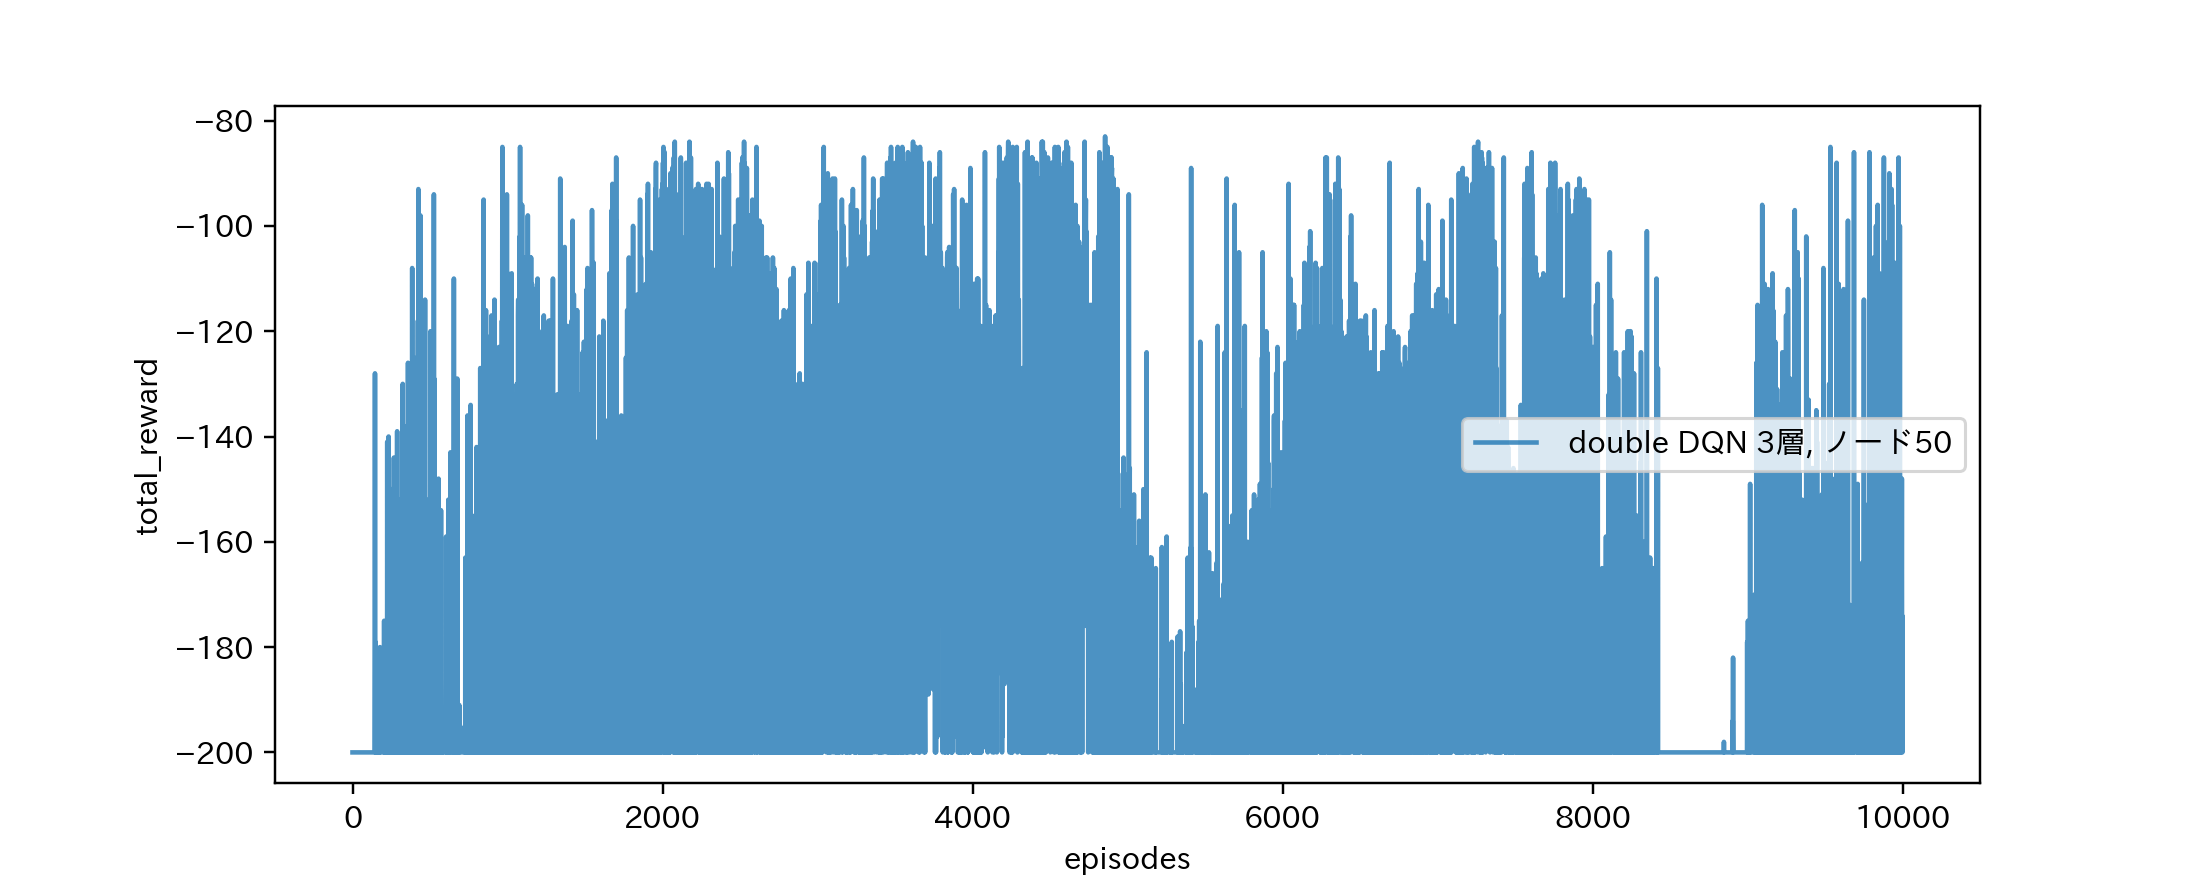

<IPython.core.display.Javascript object>


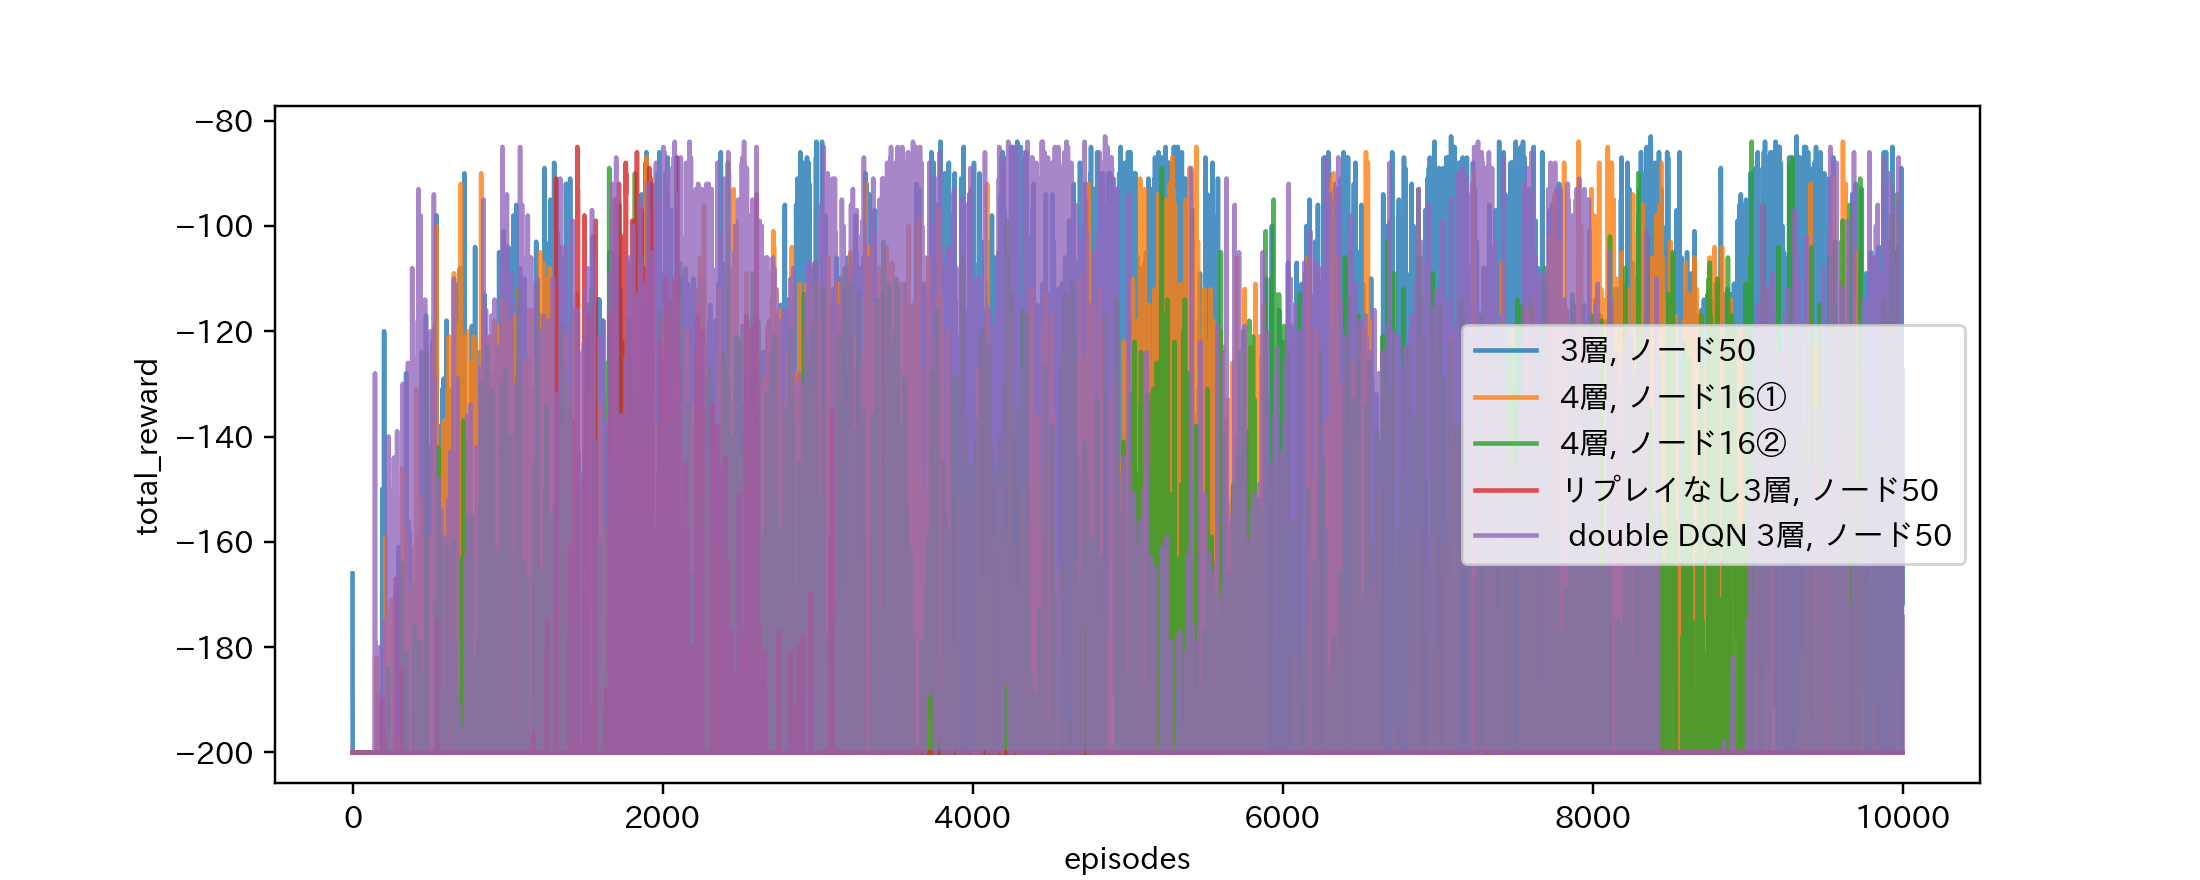

In [185]:
fig = plt.figure(figsize=(10,4))
episodes = np.arange(0,10000)
plt.plot(episodes, reward_log_dd, alpha=0.8, label=" double DQN 3層, ノード50")
plt.xlabel("episodes")
plt.ylabel("total_reward")
plt.legend(loc='center right',)
plt.show()

fig = plt.figure(figsize=(10,4))
episodes = np.arange(0,10000)
plt.plot(episodes, reward_log4, alpha=0.8, label="3層, ノード50")
plt.plot(episodes, reward_log, alpha=0.8, label="4層, ノード16①")
plt.plot(episodes, reward_log3, alpha=0.8, label="4層, ノード16②")
plt.plot(episodes, reward_log5, alpha=0.8, label="リプレイなし3層, ノード50")
plt.plot(episodes, reward_log_dd, alpha=0.8, label=" double DQN 3層, ノード50")

plt.xlabel("episodes")
plt.ylabel("total_reward")
plt.legend(loc='center right',)
plt.show()



- 一回しか試していないが、double DQNは通常のDQNに比べ、パフォーマンスの波が大きいように思われた。ただし、実装上の誤りもあるかもしれない。

## 全体的な感想
- 学習の進捗はスコアを追うしかなく、ゲームのプレイ画面上のどのタイミングで状態が取得され行動しているのかを目で追えないため、手応えを得にくいなと感じた。プレイ画面上で状態や行動が把握できる環境を作ることができれば、インタラクティブに実装上の改善ができると思われる。
- リプレイメモリは自己相関のあるデータの学習に有効であることが確認された。自己相関への対処法には他にもLSTMなどいくつかあるため、研究や情報を追っていきたい。
- 強化学習全般についての感想であるが、まず報酬をどう定義するかが重要であると思われる。現実での日常生活を考えると、報酬を一元的に決めることは難しく、時と場面によって大きく異なってくる。多義的に、重みを変えながら報酬を定義できると面白いのではと考えた。また、日常生活では行動によって環境が変わる点も重要である。強化学習分野には今後の現実場面への拡張を期待したい。